In [1]:
import io
import subprocess
import os
import glob

import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
import pickle
import re
import math
import plotnine as pn
import seaborn as sns
import glob
import subprocess
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import log
from collections import defaultdict,Counter
import re
import statsmodels
import warnings

# !pip install statannotations==0.4.0
# #!pip uninstall statannotations --yes
# from statannotations.Annotator import Annotator

warnings.filterwarnings("ignore")
pd.options.display.max_rows = None
pd.options.display.max_columns=None
pd.options.display.max_colwidth=None
work_dir="/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/BMS_SOW33_237samples_MBv4Lung_replacement_MRD_02282024"

# Data preocessing

In [2]:
#Readin samples from MRD all col csv file of BMS_SOW33_Infinity_01 batch
#Note that there are 237 samples in total and one sample failed enrichment therefore not sequenced B00484294. Need to manually add it back to the final report.

df_BMS_MRD_all = pd.read_csv(f"{work_dir}/20230919_BMS_SOW33_Infinity_01_post_tb_tb_changed_all_cols_MRD.csv", header = 0) 

print("Total sample size of BMS_SOW33_Infinity_01 batch is " + str(df_BMS_MRD_all.shape[0]) + "\n") 
print("Total unique sample size of BMS_SOW33_Infinity_01 batch is " + str(df_BMS_MRD_all.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of BMS_SOW33_Infinity_01 batch is " + str(df_BMS_MRD_all.Patient_ID.nunique()) + "\n")

#drop duplicates 
df_BMS_MRD_all_1 = df_BMS_MRD_all.drop_duplicates(subset=["GHSampleID"])
print("Total sample size of BMS_SOW33_Infinity_01 batch after removing duplications is " + str(df_BMS_MRD_all_1.shape[0]) + "\n") 
df_BMS_MRD_all_1.head()

Total sample size of BMS_SOW33_Infinity_01 batch is 302

Total unique sample size of BMS_SOW33_Infinity_01 batch is 236

Total unique patient sample size of BMS_SOW33_Infinity_01 batch is 60

Total sample size of BMS_SOW33_Infinity_01 batch after removing duplications is 236



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,fc_dir,runid,new_Cancertype,Cancer_Type_in_Cohort,Cancer_Type_Standardized,new_Cancer_Type_in_Cohort,new_Cancer_Type_Standardized,sample_id_x,max_maf,max_maf_gene,max_maf_mut_aa,max_maf_tvf_comment_multitumor,tvf_call,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,maf,Splice_effect,COSMIC,dbSNP,Mol_count,sample_id_y,tvf_comment_multitumor,run_sample_id,tumor_type,genomic_risk_score,grs_threshold,grs_call,bi_details,Percentage,Somatic_variant_reportable,Tumor_genomic_status,ctDNA_detected
0,CA209-73L,AP948176G,A0820917,B00484176,0027-01736,NSCLC,NaN,CCRTC2D1,SUCCESS,NaN,Detected,0.002372,4.914,2.0,0,06/29/2023,10/17/2022,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230909_A01835_0122_BHC7VLDSX7_PS3C134_AP1.Sirius-1.1.1-RLS,230909_A01835_0122_BHC7VLDSX7,NSCLC,NSCLC,LUNG,NSCLC,LUNG,B00484176,0.006834,TP53,R267P,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""uncommon TP53 SNV"",""BLADDER"":""uncommon TP53 SNV"",""CRC"":""uncommon TP53 SNV"",""OVARIAN"":""uncommon TP53 SNV"",""HN"":""uncommon TP53 SNV"",""GASTRIC"":""uncommon TP53 SNV"",""LIVER"":""uncommon TP53 SNV"",""MELANOMA"":""uncommon TP53 SNV"",""PANCREATIC"":""uncommon TP53 SNV"",""PROSTATE"":""uncommon TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",1,SNV,NaN,TP53,17.0,7577138.0,8.0,R267P,C>G,c.800G>C,NM_000546.6,0.006834,NaN,COSV52691512,rs587780075,462.0,B00484176,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""uncommon TP53 SNV"",""BLADDER"":""uncommon TP53 SNV"",""CRC"":""uncommon TP53 SNV"",""OVARIAN"":""uncommon TP53 SNV"",""HN"":""uncommon TP53 SNV"",""GASTRIC"":""uncommon TP53 SNV"",""LIVER"":""uncommon TP53 SNV"",""MELANOMA"":""uncommon TP53 SNV"",""PANCREATIC"":""uncommon TP53 SNV"",""PROSTATE"":""uncommon TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",B00484176,LUNG,2.128147,5.73,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 1}",0.683371,Yes,Detected,Detected
1,CA209-73L,LP044532B,A0820973,B00484236,0041-01812,NSCLC,NaN,CCRTC1D1,SUCCESS,NaN,Detected,0.008647,7.800,2.0,0,06/29/2023,11/23/2022,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230909_A01835_0122_BHC7VLDSX7_PS3C134_AP1.Sirius-1.1.1-RLS,230909_A01835_0122_BHC7VLDSX7,NSCLC,NSCLC,LUNG,NSCLC,LUNG,B00484236,0.010574,TP53,E286K,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""uncommon TP53 SNV"",""BLADDER"":""uncommon TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""uncommon TP53 SNV"",""MELANOMA"":""uncommon TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",1,SNV,NaN,TP53,17.0,7577082.0,8.0,E286K,C>T,c.856G>A,NM_000546.6,0.010574,NaN,COSV52664318,rs786201059,1349.0,B00484236,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""uncommon TP53 SNV"",""BLADDER"":""uncommon TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""uncommon TP53 SNV"",""MELANOMA"":""uncommon TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",B00484236,LUNG,1.858175,5.73,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 1}",1.057400,Yes,Detected,Detected
2,CA209-73L,LP044549B,A0820974,B00484238,0041-01812,NSCLC,NaN,CCRTC3D1,SUCCESS,NaN,Not Detected,0.000000,7.800,2.0,0,06/29/2023,01/10/2023,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230909_A01835_0122_BHC7VLDSX7_PS3C134_AP1.Sirius-1.1.1-RLS,230909_A01835_0122_BHC7VLDSX7,NSCLC,NSCLC,LUNG,NSCLC,LUNG,NaN,0.000000,NaN,NaN,NaN,0,NaN,NaN,NaN,

# Generate MB Lung v4 caller outputs
### Important Note: No need to run these section of code because Mingyang has alreday generated the outputs

In [10]:
import epicaller
import epicaller.methylation.methyl_caller

def run_mb_lung_v4_caller_wrapper_slurm(sample_meta_df, mr_model_file, workdir):
    region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_classification_space.tsv'
    control_region_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/v05_positive_control_regions.tsv'
    lr_model_file='/screening/notebooks/yhe/repo/bip-products/models/Lunar2-0.2/methylation_caller/mafband_v2023_06_30/msre_lr_model.tsv'

    jobs_dir = f"{workdir}/MB_lung_v4_NAD02_IST01_Infinity_02_jobs"
    output_dir = f"{workdir}/MB_lung_v4_NAD02_IST01_Infinity_02_output"

    # Check and create directories if not exists
    if not os.path.exists(jobs_dir):
        os.makedirs(jobs_dir)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for _, row in sample_meta_df.iterrows():
        run_sample_id = row["GHSampleID"]
        fc_dir = row["fc_dir"]
        flowcell_id = row["runid"]
        mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
        mbd_residual_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_residual_molecules.tsv"
        
        # Check if the molecule file exists
        if not os.path.exists(mbd_hyper_molecules):
            continue

        job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
        shebang_content = (f"#!/bin/bash\n"
                           f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
                           f"#SBATCH --nodes=1\n"
                           f"#SBATCH --ntasks=1\n"
                           f"#SBATCH --cpus-per-task=1\n"
                           f"#SBATCH --mem=30gb\n"
                           f"#SBATCH --partition=dev\n"
                           f"#SBATCH --time=00:10:00\n"
                           f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
        with open(job_file, "w") as job_output:
            job_output.write(shebang_content)
            job_output.write("python3 -m epicaller.methylation.methyl_caller " + 
                             f"--hyper-molecule-file {mbd_hyper_molecules} " + 
                             f"--residual-molecule-file {mbd_residual_molecules} " + 
                             f"--region-file {region_file} " +
                             f"--control-region-file {control_region_file} " + 
                             f"--lr-model-file {lr_model_file} " + 
                             f"--mr-model-file {mr_model_file} " +
                             "--min-frag-len 120 --max-frag-len 240 --min-cg-count 12 --max-cg-count 30 --cutsite-count-cutoff 1 --min-mapq 60 " + 
                             f"--sample-id {run_sample_id} --flowcell-id {flowcell_id} --outdir {output_dir}/")
            # print(job_output)    
        os.system(f"sbatch {job_file}")


In [11]:
#run the function to generate all the MB Lung v4 caller ouputs for BMS_SOW33_Infinity_01 batch 
run_mb_lung_v4_caller_wrapper_slurm(df_BMS_MRD_all_1, 
                      "/home/byounggreenwald/LungPan_v4_Caller.model_file.98_spec.tsv", 
                      f"{work_dir}")

Submitted batch job 73407575
Submitted batch job 73407576
Submitted batch job 73407577
Submitted batch job 73407579
Submitted batch job 73407580


# Generate MB Lung v4 score

In [3]:
#The function to calculate MB Lung v4 score
def calculate_MB_lung_v4_score(msre_file, mb_lung_v4_model_coef):
    msre_df = pd.read_table(msre_file)
    msre_df["region_score"] = np.log10(msre_df["hyper_residual_count"]/msre_df["hyper_residual_count_pos_ctrl"] + 1e-5)
    v6_score_df = (
        msre_df
         .merge(mb_lung_v4_model_coef, on='region_id', how='left')
        .groupby(["run_sample_id", "runid"])
        .apply(lambda x: (x["region_score"] * x["weight_y"]).sum() + x["bias_y"].iloc[0])
        .reset_index(name="v2_mb_score")
    )
    v2_score = v6_score_df.v2_mb_score.values[0]
    
    return v2_score
    

#example call
#the mb caller result folder is generated by Mingyang
mb_caller_result_folder = f"/ghds/projects/pharma/customers/BristolMyersSquibb/Infinity/BMS_SOW33_Infinity/BMS_SOW33_Infinity_01/data/summary/mb_lung_v4/mb_lung_v4_run"
mb_lung_v4_model_coef = pd.read_table("/home/byounggreenwald/LungPan_v4_Caller.model_file.98_spec.tsv")
calculate_MB_lung_v4_score(f"{mb_caller_result_folder}/B00484175/B00484175.msre_caller_mr_features.hdr.tsv", mb_lung_v4_model_coef)

-8.699510588921969

# Generate the MB Lung v4 binary results

In [4]:
#Generate MB Lung v4 score for BMS_SOW33_Infinity_01 batch
df_BMS_MRD_all_2 = df_BMS_MRD_all_1.copy()
df_BMS_MRD_all_2["MB_Lung_v4_call"] = np.nan
df_BMS_MRD_all_2["MB_Lung_v4_score"] = np.nan

#MR lung v4 score generation
mb_lung_v4_model_coef = pd.read_table("/home/byounggreenwald/LungPan_v4_Caller.model_file.98_spec.tsv")
MB_lung_v4_threshold = -20.398620396045953 #This 20.398620396045953 is the cutoff of 98% specificity for MB Lung v4 

mb_caller_result_folder = f"/ghds/projects/pharma/customers/BristolMyersSquibb/Infinity/BMS_SOW33_Infinity/BMS_SOW33_Infinity_01/data/summary/mb_lung_v4/mb_lung_v4_run"
for index, crc_row in df_BMS_MRD_all_2.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}.msre_caller_mr_features.hdr.tsv" 
    mb_score = calculate_MB_lung_v4_score(msre_mr_file, mb_lung_v4_model_coef)
    # print(mb_score)
    df_BMS_MRD_all_2.at[index, "MB_Lung_v4_score"] = mb_score
    df_BMS_MRD_all_2.at[index, "MB_Lung_v4_call"] = "Detected" if mb_score > MB_lung_v4_threshold else "Not Detected"

df_BMS_MRD_all_2.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,fc_dir,runid,new_Cancertype,Cancer_Type_in_Cohort,Cancer_Type_Standardized,new_Cancer_Type_in_Cohort,new_Cancer_Type_Standardized,sample_id_x,max_maf,max_maf_gene,max_maf_mut_aa,max_maf_tvf_comment_multitumor,tvf_call,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,maf,Splice_effect,COSMIC,dbSNP,Mol_count,sample_id_y,tvf_comment_multitumor,run_sample_id,tumor_type,genomic_risk_score,grs_threshold,grs_call,bi_details,Percentage,Somatic_variant_reportable,Tumor_genomic_status,ctDNA_detected,MB_Lung_v4_call,MB_Lung_v4_score
0,CA209-73L,AP948176G,A0820917,B00484176,0027-01736,NSCLC,NaN,CCRTC2D1,SUCCESS,NaN,Detected,0.002372,4.914,2.0,0,06/29/2023,10/17/2022,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230909_A01835_0122_BHC7VLDSX7_PS3C134_AP1.Sirius-1.1.1-RLS,230909_A01835_0122_BHC7VLDSX7,NSCLC,NSCLC,LUNG,NSCLC,LUNG,B00484176,0.006834,TP53,R267P,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""uncommon TP53 SNV"",""BLADDER"":""uncommon TP53 SNV"",""CRC"":""uncommon TP53 SNV"",""OVARIAN"":""uncommon TP53 SNV"",""HN"":""uncommon TP53 SNV"",""GASTRIC"":""uncommon TP53 SNV"",""LIVER"":""uncommon TP53 SNV"",""MELANOMA"":""uncommon TP53 SNV"",""PANCREATIC"":""uncommon TP53 SNV"",""PROSTATE"":""uncommon TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",1,SNV,NaN,TP53,17.0,7577138.0,8.0,R267P,C>G,c.800G>C,NM_000546.6,0.006834,NaN,COSV52691512,rs587780075,462.0,B00484176,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""uncommon TP53 SNV"",""BLADDER"":""uncommon TP53 SNV"",""CRC"":""uncommon TP53 SNV"",""OVARIAN"":""uncommon TP53 SNV"",""HN"":""uncommon TP53 SNV"",""GASTRIC"":""uncommon TP53 SNV"",""LIVER"":""uncommon TP53 SNV"",""MELANOMA"":""uncommon TP53 SNV"",""PANCREATIC"":""uncommon TP53 SNV"",""PROSTATE"":""uncommon TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",B00484176,LUNG,2.128147,5.73,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 1}",0.683371,Yes,Detected,Detected,Detected,-17.701394
1,CA209-73L,LP044532B,A0820973,B00484236,0041-01812,NSCLC,NaN,CCRTC1D1,SUCCESS,NaN,Detected,0.008647,7.800,2.0,0,06/29/2023,11/23/2022,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230909_A01835_0122_BHC7VLDSX7_PS3C134_AP1.Sirius-1.1.1-RLS,230909_A01835_0122_BHC7VLDSX7,NSCLC,NSCLC,LUNG,NSCLC,LUNG,B00484236,0.010574,TP53,E286K,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""uncommon TP53 SNV"",""BLADDER"":""uncommon TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""uncommon TP53 SNV"",""MELANOMA"":""uncommon TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",1,SNV,NaN,TP53,17.0,7577082.0,8.0,E286K,C>T,c.856G>A,NM_000546.6,0.010574,NaN,COSV52664318,rs786201059,1349.0,B00484236,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""uncommon TP53 SNV"",""BLADDER"":""uncommon TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""uncommon TP53 SNV"",""MELANOMA"":""uncommon TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",B00484236,LUNG,1.858175,5.73,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 1}",1.057400,Yes,Detected,Detected,Detected,-10.723566
2,CA209-73L,LP044549B,A0820974,B00484238,0041-01812,NSCLC,NaN,CCRTC3D1,SUCCESS,NaN,Not Detected,0.000000,7.800,2.0,0,06/29/2023,01/10/2023,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230909_A01835_0122_BHC7VLDSX7_PS3C134_AP1.Sirius-1.1.1-RLS,230909_A01835_0122_BHC7V

# Generate the epiTF score results

In [ ]:
#generate the forced_TF based on Sai's tutorial
import warnings

# Suppress all warnings
warnings.simplefilter(action='ignore', category=Warning)
warnings.filterwarnings('ignore')

def process_samples(df, script_dir, param_path, output_dir):
    """
    Process samples to recalculate the tumor fraction and merge the results.

    Args:
    - df (pandas.DataFrame): Dataframe with sample information.
    - script_dir (str): Directory containing the force-TF.py script.
    - param_path (str): Path to the tumor fraction model parameters.
    - output_dir (str): Directory where the merged output should be saved.

    Returns:
    - merged_file_path (str): Path to the merged output file.
    """
    output_files = []

    for index, row in df.iterrows():
        run_sample_id = row["run_sample_id"]
        runid = row["runid"]
        #This is to deal the the cluster migration issue
        fc_dir = row["fc_dir"].replace("/ghess", "/ghsfa/projects") 
        msre_call_path = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msre_all_call.hdr.tsv"
        
        # Check if the file exists
        if not os.path.exists(msre_call_path):
            print(f"No file found at {msre_call_path}")
            continue
        
        output_file = f"{output_dir}/{run_sample_id}.msre_all_call.with_forceTF.tsv"
        output_files.append(output_file)

        cmd = (f"python3 {script_dir}/force-TF.py " + 
               f"--msre-call {msre_call_path} " + 
               f"--param-path {param_path} " +
               f"--output {output_dir}/{run_sample_id}")
        os.system(cmd)

script_dir = f"{work_dir}/Forced_TF"

# Check and create directories if not exists
if not os.path.exists(script_dir):
    os.makedirs(script_dir)

script_dir = f"{work_dir}/Forced_TF"
param_path = "/ghsfa/projects/omni_v2/users/schen/epigen/pan-cancer-tf/params/tumor-fraction-model"
output_dir = script_dir



#call the function
df_BMS_MRD_all_3 = df_BMS_MRD_all_2.copy()
process_samples(df_BMS_MRD_all_3, script_dir, param_path, output_dir)


In [5]:
#retreive and incoporate forced_TF results into the currect data. The algorithm is designed based on LR model so I choose LUNG forced_TF
script_dir = f"{work_dir}/Forced_TF"
param_path = "/ghsfa/projects/omni_v2/users/schen/epigen/pan-cancer-tf/params/tumor-fraction-model"
output_dir = script_dir
df_BMS_MRD_all_3 = df_BMS_MRD_all_2.copy()


df_BMS_MRD_all_3["pred_frac_force"] = np.nan

for index, row in df_BMS_MRD_all_3.iterrows():
    run_sample_id = row["run_sample_id"]
    
    #get pred_frac_force of MB Lung v4 caller
    crc_msre_mr_file_path = f"{output_dir}/{run_sample_id}.msre_all_call.with_forceTF.tsv"
    try:
        crc_msre_mr_file_df = pd.read_table(crc_msre_mr_file_path)
        #select the LUNG model epiTF
        crc_lr_row = crc_msre_mr_file_df[crc_msre_mr_file_df["model_name"] == "LUNG"]
        pred_frac_force_crc = crc_lr_row['pred_frac_force'].iloc[0]
        df_BMS_MRD_all_3.loc[index, "pred_frac_force"] = pred_frac_force_crc
    except FileNotFoundError:
        print(f"No file found for {run_sample_id}. Assigning np.nan to mb_score.")
    except Exception as e:
        print(f"An error occurred with {run_sample_id}: {str(e)}")   
        
df_BMS_MRD_all_3.head()

No file found for nan. Assigning np.nan to mb_score.


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,fc_dir,runid,new_Cancertype,Cancer_Type_in_Cohort,Cancer_Type_Standardized,new_Cancer_Type_in_Cohort,new_Cancer_Type_Standardized,sample_id_x,max_maf,max_maf_gene,max_maf_mut_aa,max_maf_tvf_comment_multitumor,tvf_call,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,maf,Splice_effect,COSMIC,dbSNP,Mol_count,sample_id_y,tvf_comment_multitumor,run_sample_id,tumor_type,genomic_risk_score,grs_threshold,grs_call,bi_details,Percentage,Somatic_variant_reportable,Tumor_genomic_status,ctDNA_detected,MB_Lung_v4_call,MB_Lung_v4_score,pred_frac_force
0,CA209-73L,AP948176G,A0820917,B00484176,0027-01736,NSCLC,NaN,CCRTC2D1,SUCCESS,NaN,Detected,0.002372,4.914,2.0,0,06/29/2023,10/17/2022,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230909_A01835_0122_BHC7VLDSX7_PS3C134_AP1.Sirius-1.1.1-RLS,230909_A01835_0122_BHC7VLDSX7,NSCLC,NSCLC,LUNG,NSCLC,LUNG,B00484176,0.006834,TP53,R267P,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""uncommon TP53 SNV"",""BLADDER"":""uncommon TP53 SNV"",""CRC"":""uncommon TP53 SNV"",""OVARIAN"":""uncommon TP53 SNV"",""HN"":""uncommon TP53 SNV"",""GASTRIC"":""uncommon TP53 SNV"",""LIVER"":""uncommon TP53 SNV"",""MELANOMA"":""uncommon TP53 SNV"",""PANCREATIC"":""uncommon TP53 SNV"",""PROSTATE"":""uncommon TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",1,SNV,NaN,TP53,17.0,7577138.0,8.0,R267P,C>G,c.800G>C,NM_000546.6,0.006834,NaN,COSV52691512,rs587780075,462.0,B00484176,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""uncommon TP53 SNV"",""BLADDER"":""uncommon TP53 SNV"",""CRC"":""uncommon TP53 SNV"",""OVARIAN"":""uncommon TP53 SNV"",""HN"":""uncommon TP53 SNV"",""GASTRIC"":""uncommon TP53 SNV"",""LIVER"":""uncommon TP53 SNV"",""MELANOMA"":""uncommon TP53 SNV"",""PANCREATIC"":""uncommon TP53 SNV"",""PROSTATE"":""uncommon TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",B00484176,LUNG,2.128147,5.73,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 1}",0.683371,Yes,Detected,Detected,Detected,-17.701394,0.002372
1,CA209-73L,LP044532B,A0820973,B00484236,0041-01812,NSCLC,NaN,CCRTC1D1,SUCCESS,NaN,Detected,0.008647,7.800,2.0,0,06/29/2023,11/23/2022,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230909_A01835_0122_BHC7VLDSX7_PS3C134_AP1.Sirius-1.1.1-RLS,230909_A01835_0122_BHC7VLDSX7,NSCLC,NSCLC,LUNG,NSCLC,LUNG,B00484236,0.010574,TP53,E286K,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""uncommon TP53 SNV"",""BLADDER"":""uncommon TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""uncommon TP53 SNV"",""MELANOMA"":""uncommon TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",1,SNV,NaN,TP53,17.0,7577082.0,8.0,E286K,C>T,c.856G>A,NM_000546.6,0.010574,NaN,COSV52664318,rs786201059,1349.0,B00484236,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""uncommon TP53 SNV"",""BLADDER"":""uncommon TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""uncommon TP53 SNV"",""MELANOMA"":""uncommon TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""uncommon TP53 SNV""}",B00484236,LUNG,1.858175,5.73,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 1}",1.057400,Yes,Detected,Detected,Detected,-10.723566,0.008647
2,CA209-73L,LP044549B,A0820974,B00484238,0041-01812,NSCLC,NaN,CCRTC3D1,SUCCESS,NaN,Not Detected,0.000000,7.800,2.0,0,06/29/2023,01/10/2023,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230909_A01835_0122_BHC7VLDSX7_PS3C134_AP1.Sirius-

# Generate the MRD report with MB Lung v4 caller and epiTF result

In [27]:
#readin the MRD report (original deliverable version (changed_RUO_report_MRD.csv)) of BMS_SOW33_Infinity_01 batch
df_BMS_MRD_simple = pd.read_csv(f"{work_dir}/20230919_BMS_SOW33_Infinity_01_post_tb_tb_changed_RUO_report_MRD.csv", header = 0) 
print(df_BMS_MRD_simple.shape)
# Get the list of columns present in both df_BMS_MRD_all_3 and df_BMS_MRD_simple
common_columns = df_BMS_MRD_all_3.columns.intersection(df_BMS_MRD_simple.columns)

# Ensure that MB_Lung_v4_call and MB_Lung_v4_score are included in the final DataFrame
additional_columns = ["MB_Lung_v4_call", "MB_Lung_v4_score", "pred_frac_force"]
final_columns = common_columns.tolist() + [col for col in additional_columns if col in df_BMS_MRD_all_3.columns]

# Create a df with all the columns in the original deliverable version with addtional columns 
df_BMS_MRD_final_full = df_BMS_MRD_all_3[final_columns]

#save the output for later report generation purpose
df_BMS_MRD_final = pd.merge(df_BMS_MRD_simple, df_BMS_MRD_final_full[['GHSampleID', 'MB_Lung_v4_call', 'pred_frac_force']], on="GHSampleID", how='left')
print(df_BMS_MRD_final.shape)
df_BMS_MRD_final.head()

(278, 35)
(278, 37)


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,Somatic_variant_reportable,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,COSMIC,dbSNP,Mol_count,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,MB_Lung_v4_call,pred_frac_force
0,CA209-73L,AP948176G,A0820917,B00484176,0027-01736,NSCLC,NaN,CCRTC2D1,SUCCESS,NaN,Detected,Detected,0.002372,Yes,SNV,NaN,TP53,17.0,7577138.0,8.0,R267P,C>G,c.800G>C,NM_000546.6,0.683371,NaN,COSV52691512,rs587780075,462.0,4.914,2.0,0,06/29/2023,10/17/2022,09/19/2023,Detected,0.002372
1,CA209-73L,LP044532B,A0820973,B00484236,0041-01812,NSCLC,NaN,CCRTC1D1,SUCCESS,NaN,Detected,Detected,0.008647,Yes,SNV,NaN,TP53,17.0,7577082.0,8.0,E286K,C>T,c.856G>A,NM_000546.6,1.057400,NaN,COSV52664318,rs786201059,1349.0,7.800,2.0,0,06/29/2023,11/23/2022,09/19/2023,Detected,0.008647
2,CA209-73L,LP044549B,A0820974,B00484238,0041-01812,NSCLC,NaN,CCRTC3D1,SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.800,2.0,0,06/29/2023,01/10/2023,09/19/2023,Not Detected,0.002106
3,CA209-73L,LP044579B,A0820975,B00484232,0041-01812,NSCLC,NaN,MAINTC1D1,SUCCESS,NaN,Detected,Detected,0.002139,Yes,SNV,NaN,ATM,11.0,108236086.0,63.0,R3008C,C>T,c.9022C>T,NM_000051.4,1.488220,NaN,COSV53730980,rs587782292,2470.0,13.572,2.0,0,06/29/2023,02/24/2023,09/19/2023,Detected,0.002139
4,CA209-73L,LP044579B,A0820975,B00484232,0041-01812,NSCLC,NaN,MAINTC1D1,SUCCESS,NaN,Detected,Detected,0.002139,Yes,SNV,NaN,TP53,17.0,7577139.0,8.0,R267W,G>A,c.799C>T,NM_000546.6,0.106895,NaN,COSV52678166,rs55832599,1921.0,13.572,2.0,0,06/29/2023,02/24/2023,09/19/2023,Detected,0.002139


In [28]:
#create a testing case to evaluate the report generation logic 
df_BMS_MRD_all = pd.read_csv(f"{work_dir}/20230919_BMS_SOW33_Infinity_01_post_tb_tb_changed_all_cols_MRD.csv", header = 0) 

#change a somatic variant call reportable from "No" to "Yes"for a flipped call (LR-MB+) for sample B00484282
df_BMS_MRD_all.loc[df_BMS_MRD_all["GHSampleID"] == "B00484282", "Somatic_variant_reportable"] = "Yes"

#add two more somatic variants calls for sample B00484282 by duplicate it's original one and only change its "Gene" name
original_row = df_BMS_MRD_all.loc[df_BMS_MRD_all['GHSampleID'] == 'B00484282'].iloc[0].copy()

#Create two new rows based on the original, changing 'Gene' to 'fake1' and 'fake2'
new_row_1 = original_row.copy()
new_row_1['Gene'] = 'fake1'
new_row_2 = original_row.copy()
new_row_2['Gene'] = 'fake2'

#ensure 'Somatic_variant_reportable' is 'Yes' for these rows (not change any of them to "No" for testing purpose)
new_row_1['Somatic_variant_reportable'] = 'Yes'
new_row_2['Somatic_variant_reportable'] = 'Yes'

#Append these new rows to df_BMS_MRD_all
df_BMS_MRD_all = df_BMS_MRD_all.append([new_row_1, new_row_2], ignore_index=True)

# Verification: Check the newly added rows for B00484282
df_BMS_MRD_all_test = df_BMS_MRD_all[df_BMS_MRD_all["GHSampleID"] == "B00484282"]
df_BMS_MRD_all_test

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,Tumor_methylation_status,Tumor_methylation_score,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,fc_dir,runid,new_Cancertype,Cancer_Type_in_Cohort,Cancer_Type_Standardized,new_Cancer_Type_in_Cohort,new_Cancer_Type_Standardized,sample_id_x,max_maf,max_maf_gene,max_maf_mut_aa,max_maf_tvf_comment_multitumor,tvf_call,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,maf,Splice_effect,COSMIC,dbSNP,Mol_count,sample_id_y,tvf_comment_multitumor,run_sample_id,tumor_type,genomic_risk_score,grs_threshold,grs_call,bi_details,Percentage,Somatic_variant_reportable,Tumor_genomic_status,ctDNA_detected
135,CA209-73L,SP092840D,A0820990,B00484282,0205-01210,NSCLC,NaN,MAINTC2D1,SUCCESS,NaN,Not Detected,0.0,16.276,2.0,0,08/03/2023,05/17/2022,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230909_A02048_0023_AHCFFCDSX7_PS3C135_AP1.Sirius-1.1.1-RLS,230909_A02048_0023_AHCFFCDSX7,NSCLC,NSCLC,LUNG,NSCLC,LUNG,B00484282,0.00543,TP53,R175H,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""common subclonal TP53 SNV"",""BLADDER"":""common subclonal TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""common clonal TP53 SNV"",""MELANOMA"":""common clonal TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""common clonal TP53 SNV""}",1,SNV,NaN,TP53,17.0,7578406.0,5.0,R175H,C>T,c.524G>A,NM_000546.6,0.00543,NaN,COSV52661038,rs28934578,2466.0,B00484282,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""common subclonal TP53 SNV"",""BLADDER"":""common subclonal TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""common clonal TP53 SNV"",""MELANOMA"":""common clonal TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""common clonal TP53 SNV""}",B00484282,LUNG,1.987233,5.73,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 1}",0.543024,Yes,Not Detected,Not Detected
302,CA209-73L,SP092840D,A0820990,B00484282,0205-01210,NSCLC,NaN,MAINTC2D1,SUCCESS,NaN,Not Detected,0.0,16.276,2.0,0,08/03/2023,05/17/2022,09/19/2023,/ghess/pharma/to_move/Sirius_REPORTING/fc_dir_softlink/230909_A02048_0023_AHCFFCDSX7_PS3C135_AP1.Sirius-1.1.1-RLS,230909_A02048_0023_AHCFFCDSX7,NSCLC,NSCLC,LUNG,NSCLC,LUNG,B00484282,0.00543,TP53,R175H,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""common subclonal TP53 SNV"",""BLADDER"":""common subclonal TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""common clonal TP53 SNV"",""MELANOMA"":""common clonal TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""common clonal TP53 SNV""}",1,SNV,NaN,fake1,17.0,7578406.0,5.0,R175H,C>T,c.524G>A,NM_000546.6,0.00543,NaN,COSV52661038,rs28934578,2466.0,B00484282,"{""LUNG"":""common clonal TP53 SNV"",""BREAST"":""common subclonal TP53 SNV"",""BLADDER"":""common subclonal TP53 SNV"",""CRC"":""common subclonal TP53 SNV"",""OVARIAN"":""common clonal TP53 SNV"",""HN"":""common clonal TP53 SNV"",""GASTRIC"":""common clonal TP53 SNV"",""LIVER"":""common clonal TP53 SNV"",""MELANOMA"":""common clonal TP53 SNV"",""PANCREATIC"":""common clonal TP53 SNV"",""PROSTATE"":""common clonal TP53 SNV"",""RCC"":""common clonal TP53 SNV""}",B00484282,LUNG,1.987233,5.73,0.0,"{""grs_super_whitelist"": 0, ""tvf_call"": 1}",0.543024,Yes,Not Detected,Not Detected
303,CA209-73L,SP092840D,A0820990,B00484282,0205-01210,NSCLC,NaN,MAINTC2D1,SUCCESS,NaN,Not Detected,0.0,16.276,2.0,0,08/03/2023,05/17/2022,09/19/2023,/ghe

In [30]:
#Generate the MRD report with MB Lung v4 caller and epiTF result
df_BMS_MRD_update = df_BMS_MRD_final.copy()
df_BMS_MRD_all = pd.read_csv(f"{work_dir}/20230919_BMS_SOW33_Infinity_01_post_tb_tb_changed_all_cols_MRD.csv", header = 0) 

# Part 1: Addressing flipped calls where "ctDNA_detected" is Not Detected but "MB_Lung_v4_call" is Detected
inconsistent_ids_detected_not = df_BMS_MRD_update.loc[
    (df_BMS_MRD_update['ctDNA_detected'] == 'Not Detected') & 
    (df_BMS_MRD_update['MB_Lung_v4_call'] == 'Detected'), 
    'GHSampleID'
].unique()

# Identify the GHSampleIDs that need to make updates in the new deliverable report. They should be:
    ## 1."ctDNA_detected" is Not Detected but "MB_Lung_v4_call" is Detected
    ## 2. No reportable somatic variants in the original report (i.e "Somatic_variant_reportable" is "No")
    ## 3. There are reportable somatic variants in the all_col_MRD.csv report for these samples (i.e "Somatic_variant_reportable" is "Yes")
ids_with_variants_yes = df_BMS_MRD_all[df_BMS_MRD_all['Somatic_variant_reportable'] == 'Yes']['GHSampleID'].unique()
ids_to_update = [id_ for id_ in inconsistent_ids_detected_not if id_ in ids_with_variants_yes]

# Removing original "Somatic_variant_reportable" is "No" rows for these specific GHSampleIDs from df_BMS_MRD_update before incoporting the reportable somatic variant calls from all_col_MRD.csv report
df_BMS_MRD_update = df_BMS_MRD_update.loc[~((df_BMS_MRD_update['GHSampleID'].isin(ids_to_update)) & 
                                            (df_BMS_MRD_update['Somatic_variant_reportable'] == 'No'))]

# Append any reportable somatic variant calls from all_col_MRD.csv report (i.e "Somatic_variant_reportable" is "Yes") from df_BMS_MRD_all for these ids
for ghsampleid in ids_to_update:
    relevant_variants = df_BMS_MRD_all[(df_BMS_MRD_all['GHSampleID'] == ghsampleid) & 
                                       (df_BMS_MRD_all['Somatic_variant_reportable'] == 'Yes')]
    for _, variant_row in relevant_variants.iterrows():
        # Check if the variant already exists in df_BMS_MRD_update
        if not df_BMS_MRD_update[(df_BMS_MRD_update['GHSampleID'] == variant_row['GHSampleID']) & 
                                 (df_BMS_MRD_update['Gene'] == variant_row['Gene'])].empty:
            continue  # Skip if this exact variant exists
        # Append the variant to df_BMS_MRD_update
        df_BMS_MRD_update = pd.concat([df_BMS_MRD_update, pd.DataFrame([variant_row])], ignore_index=True)
        
# Part 2: Addressing flipped calls where ctDNA_detected is Detected and MB_Lung_v4_call is Not Detected
# Identify samples where "ctDNA_detected" is "Detected" and "MB_Lung_v4_call" is "Not Detected"
flipped_ids_ctDNA_detected = df_BMS_MRD_update[
    (df_BMS_MRD_update['ctDNA_detected'] == 'Detected') & 
    (df_BMS_MRD_update['MB_Lung_v4_call'] == 'Not Detected')
]['GHSampleID'].unique()

# Define columns to change (replace with NaN) in the flipped call scenario where "ctDNA_detected" is Detected but "MB_Lung_v4_call" is Not Detected
columns_to_nullify = [
    'Variant_type', 'Indel_type', 'Gene', 'Chromosome', 'Position', 'Exon', 
    'Mut_aa', 'Mut_nt', 'Mut_cdna', 'Transcript', 'Percentage', 'Splice_effect', 
    'COSMIC', 'dbSNP', 'Mol_count'
]

# Only need to consider the case where GHSampleIDs with "Somatic_variant_reportable" as "Yes" for specific action
for sample_id in flipped_ids_ctDNA_detected:
    # Filter for rows with this sample ID where "Somatic_variant_reportable" is "Yes"
    rows_to_modify = df_BMS_MRD_update[
        (df_BMS_MRD_update['GHSampleID'] == sample_id) & 
        (df_BMS_MRD_update['Somatic_variant_reportable'] == 'Yes')
    ].index
    
    if len(rows_to_modify) > 0:
        # If there are rows to modify, proceed to nullify columns and set "Somatic_variant_reportable" to "No"
        # Select the first row to modify
        first_row_index = rows_to_modify[0]
        df_BMS_MRD_update.loc[first_row_index, 'Somatic_variant_reportable'] = 'No'
        df_BMS_MRD_update.loc[first_row_index, columns_to_nullify] = np.nan
        
        # If more than one row exists, remove the extra rows
        if len(rows_to_modify) > 1:
            df_BMS_MRD_update.drop(index=rows_to_modify[1:], inplace=True)

# Part 3: Handling NaN "ctDNA_detected" values remains unchanged

# Final duplication check and DataFrame shape verification
df_BMS_MRD_update.drop_duplicates(inplace=True)
print(df_BMS_MRD_update.shape)
        
# Part 3: Handling samples with "ctDNA_detected" as NaN (e.g. failed samples due to "failed methylation" flag)
nan_ctDNA_idxs = df_BMS_MRD_update[df_BMS_MRD_update['ctDNA_detected'].isna()].index

# Set "MB_Lung_v4_call" and "pred_frac_force" to NaN for these rows
df_BMS_MRD_update.loc[nan_ctDNA_idxs, 'MB_Lung_v4_call'] = np.nan
df_BMS_MRD_update.loc[nan_ctDNA_idxs, 'pred_frac_force'] = np.nan

# Ensure no unintended duplicates exist after this additional processing
df_BMS_MRD_update = df_BMS_MRD_update.drop_duplicates()

#save the final output
# List of original columns in deliverable MRD report
original_columns = df_BMS_MRD_final.columns.tolist()

# Subset df_BMS_MRD_update to retain only those columns present in deliverable MRD report
df_BMS_MRD_update = df_BMS_MRD_update[original_columns]
df_BMS_MRD_update.to_csv(f"{work_dir}/BMS_SOW33_Infinity_01_withMBlungV4_MRD.csv", index = False)

print(df_BMS_MRD_update.shape)
df_BMS_MRD_update.head()


(268, 37)
(268, 37)


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,Somatic_variant_reportable,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,COSMIC,dbSNP,Mol_count,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,MB_Lung_v4_call,pred_frac_force
0,CA209-73L,AP948176G,A0820917,B00484176,0027-01736,NSCLC,NaN,CCRTC2D1,SUCCESS,NaN,Detected,Detected,0.002372,Yes,SNV,NaN,TP53,17.0,7577138.0,8.0,R267P,C>G,c.800G>C,NM_000546.6,0.683371,NaN,COSV52691512,rs587780075,462.0,4.914,2.0,0,06/29/2023,10/17/2022,09/19/2023,Detected,0.002372
1,CA209-73L,LP044532B,A0820973,B00484236,0041-01812,NSCLC,NaN,CCRTC1D1,SUCCESS,NaN,Detected,Detected,0.008647,Yes,SNV,NaN,TP53,17.0,7577082.0,8.0,E286K,C>T,c.856G>A,NM_000546.6,1.057400,NaN,COSV52664318,rs786201059,1349.0,7.800,2.0,0,06/29/2023,11/23/2022,09/19/2023,Detected,0.008647
2,CA209-73L,LP044549B,A0820974,B00484238,0041-01812,NSCLC,NaN,CCRTC3D1,SUCCESS,NaN,Not Detected,Not Detected,0.000000,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.800,2.0,0,06/29/2023,01/10/2023,09/19/2023,Not Detected,0.002106
3,CA209-73L,LP044579B,A0820975,B00484232,0041-01812,NSCLC,NaN,MAINTC1D1,SUCCESS,NaN,Detected,Detected,0.002139,Yes,SNV,NaN,ATM,11.0,108236086.0,63.0,R3008C,C>T,c.9022C>T,NM_000051.4,1.488220,NaN,COSV53730980,rs587782292,2470.0,13.572,2.0,0,06/29/2023,02/24/2023,09/19/2023,Detected,0.002139
4,CA209-73L,LP044579B,A0820975,B00484232,0041-01812,NSCLC,NaN,MAINTC1D1,SUCCESS,NaN,Detected,Detected,0.002139,Yes,SNV,NaN,TP53,17.0,7577139.0,8.0,R267W,G>A,c.799C>T,NM_000546.6,0.106895,NaN,COSV52678166,rs55832599,1921.0,13.572,2.0,0,06/29/2023,02/24/2023,09/19/2023,Detected,0.002139


In [24]:
df_BMS_MRD_final.head()
#check and compare the new output with the original one

#check new ouput
#check for the flipped calls where "ctDNA_detected" is Not Detected but "MB_Lung_v4_call" is Detected
df_flip_LRnegMBpos_new = df_BMS_MRD_update[df_BMS_MRD_update['GHSampleID'].isin(inconsistent_ids_detected_not)]
print(df_flip_LRnegMBpos_new.shape)
df_flip_LRnegMBpos_new

#check for the flipped calls where "ctDNA_detected" is Detected but "MB_Lung_v4_call" is Not Detected
df_flip_LRposMBneg_new = df_BMS_MRD_update[df_BMS_MRD_update['GHSampleID'].isin(flipped_ids_ctDNA_detected)]
print(df_flip_LRposMBneg_new.shape)
df_flip_LRposMBneg_new

#check original ouput
#check for the flipped calls where "ctDNA_detected" is Not Detected but "MB_Lung_v4_call" is Detected
df_flip_LRnegMBpos_ori = df_BMS_MRD_final[df_BMS_MRD_final['GHSampleID'].isin(inconsistent_ids_detected_not)]
print(df_flip_LRnegMBpos_ori.shape)
df_flip_LRnegMBpos_ori

#check for the flipped calls where "ctDNA_detected" is Detected but "MB_Lung_v4_call" is Not Detected
df_flip_LRposMBneg_ori = df_BMS_MRD_final[df_BMS_MRD_final['GHSampleID'].isin(flipped_ids_ctDNA_detected)]
print(df_flip_LRposMBneg_ori.shape)
df_flip_LRposMBneg_ori.head()

#compare original and new output in parallel
# df_flip_LRposMBneg_new
# df_flip_LRposMBneg_ori
# df_flip_LRnegMBpos_new
# df_flip_LRnegMBpos_ori

(13, 37)
(45, 37)
(11, 37)
(55, 37)


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Cancertype,Tumor_stage,Visit_name,Sample_status,Sample_comment,ctDNA_detected,Tumor_methylation_status,Tumor_methylation_score,Somatic_variant_reportable,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,COSMIC,dbSNP,Mol_count,cfDNA_ng_yield,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,MB_Lung_v4_call,pred_frac_force
10,CA209-73L,AP331948G,A0820906,B00484201,0071-01398,NSCLC,NaN,CCRTC3D1,SUCCESS,NaN,Detected,Detected,0.001056,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.7856,2.0,0,06/29/2023,04/28/2022,09/19/2023,Not Detected,0.001056
11,CA209-73L,AP331953G,A0820907,B00484202,0071-01398,NSCLC,NaN,MAINTC1D1,SUCCESS,NaN,Detected,Detected,0.000558,Yes,SNV,NaN,TP53,17.0,7577539.0,7.0,R248W,G>A,c.742C>T,NM_000546.6,0.062344,NaN,COSV52662035,rs121912651,5015.0,64.4800,2.0,0,06/29/2023,06/24/2022,09/19/2023,Not Detected,0.000558
13,CA209-73L,AP331956G,A0820910,B00484189,0071-01398,NSCLC,NaN,MAINTC3D1,SUCCESS,NaN,Detected,Detected,0.001225,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.3124,2.0,0,06/29/2023,08/19/2022,09/19/2023,Not Detected,0.001225
14,CA209-73L,AP060738H,A0820899,B00484234,0078-01777,NSCLC,NaN,MAINTC1D1,SUCCESS,NaN,Detected,Detected,0.000966,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.1000,2.0,0,06/29/2023,01/05/2023,09/19/2023,Not Detected,0.000966
17,CA209-73L,AP916363G,A0820916,B00484179,0078-01777,NSCLC,NaN,CCRTC3D1,SUCCESS,NaN,Detected,Detected,0.001249,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.4880,2.0,0,06/29/2023,11/08/2022,09/19/2023,Not Detected,0.001249


# Data Visualization

## alluvial plot

In [36]:
import plotly.graph_objects as go

#drop the failed samples based on column "ctDNA_detected"
df_BMS_MRD_plot = df_BMS_MRD_update.dropna(subset=['ctDNA_detected'])
print(df_BMS_MRD_update.shape)
print(df_BMS_MRD_plot.shape)

#rename the columns to indicate the caller name
df_BMS_MRD_plot = df_BMS_MRD_plot.rename(columns={"ctDNA_detected": "LR_lung_call", "MB_Lung_v4_call": "MB_Lung_v4_call"})

# Prepare the data for the alluvial plot
df_methods = df_BMS_MRD_plot[["LR_lung_call", "MB_Lung_v4_call"]]
df_methods['LR_lung_call'] = df_methods['LR_lung_call'].apply(lambda x: 'Positive' if x == 'Detected' else 'Negative')
df_methods['MB_Lung_v4_call'] = df_methods['MB_Lung_v4_call'].apply(lambda x: 'Positive' if x == 'Detected' else 'Negative')

# Calculate the counts
lr_positive_mb_negative = len(df_methods[(df_methods['LR_lung_call'] == 'Positive') & (df_methods['MB_Lung_v4_call'] == 'Negative')])
lr_negative_mb_positive = len(df_methods[(df_methods['LR_lung_call'] == 'Negative') & (df_methods['MB_Lung_v4_call'] == 'Positive')])
both_positive = len(df_methods[(df_methods['LR_lung_call'] == 'Positive') & (df_methods['MB_Lung_v4_call'] == 'Positive')])
both_negative = len(df_methods[(df_methods['LR_lung_call'] == 'Negative') & (df_methods['MB_Lung_v4_call'] == 'Negative')])

# Define a minimum visual threshold for the line width 
min_visual_threshold = 20  # Adjust this value as needed for visibility

# Adjusted values for visual representation
visual_values = [
    max(both_positive, min_visual_threshold),
    max(lr_positive_mb_negative, min_visual_threshold),
    max(lr_negative_mb_positive, min_visual_threshold),
    max(both_negative, min_visual_threshold)
]

# Define Sankey diagram structure with adjusted visual values
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=["LR Positive", "LR Negative", "MB Positive", "MB Negative"],
    ),
    link=dict(
        source=[0, 0, 1, 1],  # Indices correspond to 'label' above
        target=[2, 3, 2, 3],
        value=visual_values,  # Use adjusted visual values
        color=['rgba(0, 128, 128, 0.8)', 'rgba(255, 69, 0, 0.8)', 'rgba(138, 43, 226, 0.8)', 'rgba(128, 128, 128, 0.8)']
    ))])

# Update annotations with actual counts
annotations = [
    go.layout.Annotation(x=0.1, y=0.95, xref='paper', yref='paper', showarrow=False, 
                         text=f'Consistent Calls (LR+/MB+): {both_positive}'),
    go.layout.Annotation(x=0.1, y=0.03, xref='paper', yref='paper', showarrow=False, 
                         text=f'Consistent Calls (LR-/MB-): {both_negative}'),
    go.layout.Annotation(x=0.9, y=0.45, xref='paper', yref='paper', showarrow=False, 
                         text=f'Flipped Calls (LR+/MB-): {lr_positive_mb_negative}'),
    go.layout.Annotation(x=0.9, y=0.58, xref='paper', yref='paper', showarrow=False, 
                         text=f'Flipped Calls (LR-/MB+): {lr_negative_mb_positive}')
]

fig.update_layout(title_text="Comparison between LR Lung Caller and MB lung v4 Caller on BMS_SOW33_Infinity_01 batch", annotations=annotations)

fig.show()

(268, 37)
(267, 37)


## Confusion Matrix

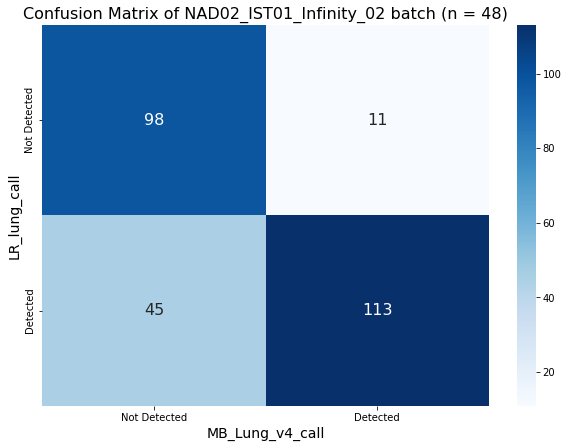

Cohen's Kappa: 0.59


In [37]:
#For batch BMS_SOW33_Infinity_01

from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0
df_BMS_MRD_plot['LR_lung_call_mapped'] = df_BMS_MRD_plot['LR_lung_call'].map({"Detected": 1, "Not Detected": 0})
df_BMS_MRD_plot['MB_Lung_v4_call_mapped'] = df_BMS_MRD_plot['MB_Lung_v4_call'].map({"Detected": 1, "Not Detected": 0})

# Extracting the values for confusion matrix calculation
y_true = df_BMS_MRD_plot['LR_lung_call_mapped'].values
y_pred = df_BMS_MRD_plot['MB_Lung_v4_call_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"], annot_kws={"size": 16})
plt.xlabel('MB_Lung_v4_call', fontsize=14)
plt.ylabel('LR_lung_call', fontsize=14)
plt.title('Confusion Matrix of NAD02_IST01_Infinity_02 batch (n = 48)', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")